In [1]:
from time import time
import numpy as np
from matplotlib import pyplot as plt

# Qiskit
from qiskit import IBMQ

# Local modules
from utilities import startup, check_provider
from graphstate import GraphState, calc_negativities, calc_n_mean, get_negativity_info, get_largest_connected, get_mean_cnot, filter_edges, calc_n
from visualization import plot_negativities_multi, plot_cxerr_corr, plot_negativities127, plot_nmap127

provider = startup()

Account enabled


## Negativity Decays

In [2]:
def list_retrieve_jobs(job_ids):
    for i, job_id in enumerate(job_ids):
        print(f'job{i+1} = provider.backend.retrieve_job(\'{job_id}\')')

#### Plotting Functions

In [77]:
def collate_n_lists(n_lists):
    return {key: [n_list[key] for n_list in n_lists] for key in n_lists[0]}

def calc_nmean_decay(n_decays):
    n_array = np.zeros((len(n_decays[(0, 1)]), len(n_decays)))
    n_array = np.zeros((len(n_decays[(0, 1)]), len(n_decays)))
    for i, value in enumerate(n_decays.values()):
        n_array[:,i] = np.array(value)
    return np.mean(n_array, axis=1), np.std(n_array, axis=1)

def plot_ndecays(n_lists, edges, step, label=None, fig=None):
    figsize = (7, 5)
    if fig is None:
        fig, ax = plt.subplots()
    else:
        ax = plt.gca()
    n_decays = collate_n_lists(n_lists)
    
    try:
        X = np.arange(0, step*len(n_decays[(0, 1)]), step)
        if edges == 'all':
            for edge, Y in n_decays.items():
                ax.plot(X, Y, label=label)
        elif edges == 'mean':
            Y, Ystd = calc_nmean_decay(n_decays)
            ax.errorbar(X, Y, yerr=Ystd, label=label, marker='o', markersize=4, ls='--', elinewidth=1, capsize=3)
            ax.set_title('Mean device negativity decay')
        else:
            for edge in edges:
                Y = n_decays[edge]
                ax.plot(X, Y, label=label, marker='o')
    except:
        Y = n_decays[edges]
        X = np.arange(0, step*len(X), step)
        ax.plot(X, Y, label=label, marker='o', markersize=4)
        
    ax.grid(True)
    ax.set_xlabel('Delay $\it{t}$ (μs)')
    ax.set_ylabel('Negativity')
    ax.set_yticks(np.arange(0, 0.55, 0.05))
    fig.set_tight_layout(True)
    
    if label is not None:
        ax.legend()
        pass
        
    return fig

#### Simulation

In [37]:
from qiskit import Aer, transpile, QuantumCircuit, execute
from qiskit_aer.noise import NoiseModel

ModuleNotFoundError: No module named 'qiskit_aer'

In [4]:
backend = Aer.get_backend('aer_simulator_density_matrix')

In [5]:
circ1 = QuantumCircuit(2)
circ1.h(0)
circ1.cx(0, 1)
circ1.delay(10000)

circ1.save_density_matrix()
circ1.draw()

┌───┐     ┌──────────────────┐ density_matrix 
q_0: ┤ H ├──■──┤ Delay(10000[dt]) ├───────░────────
     └───┘┌─┴─┐├──────────────────┤       ░        
q_1: ─────┤ X ├┤ Delay(10000[dt]) ├───────░────────
          └───┘└──────────────────┘       ░

In [6]:
circ2 = QuantumCircuit(2)
circ2.h(0)
circ2.h(1)
circ2.cz(0, 1)
circ2.delay(10000)

circ2.save_density_matrix()
circ2.draw()

┌───┐   ┌──────────────────┐ density_matrix 
q_0: ┤ H ├─■─┤ Delay(10000[dt]) ├───────░────────
     ├───┤ │ ├──────────────────┤       ░        
q_1: ┤ H ├─■─┤ Delay(10000[dt]) ├───────░────────
     └───┘   └──────────────────┘       ░

In [7]:
sim = provider.get_backend('ibmq_montreal')
noise_model = NoiseModel.from_backend(sim)

In [8]:
data = execute(circ1, backend=backend, noise_model=noise_model).result().data()
rho = data.get('density_matrix')
calc_n(rho)

0.4093014719891695

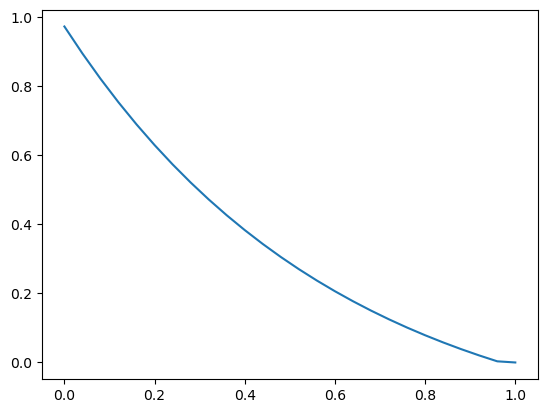

In [263]:
t_list = [i*5000 for i in range(26)]
circ_list = []
n_list = []
for i, t in enumerate(t_list):
    circ = QuantumCircuit(2)
    circ.h(0)
    circ.cx(0, 1)
    circ.delay(t)

    circ.save_density_matrix()
    data = execute(circ, backend=backend, noise_model=noise_model).result().data()
    rho = data.get('density_matrix')
    n_list.append(calc_n(rho))
    
t_max = t_list[-1]
t_list = [t/t_max for t in t_list]
n_list = [n*2 for n in n_list]
plt.plot(t_list, n_list)

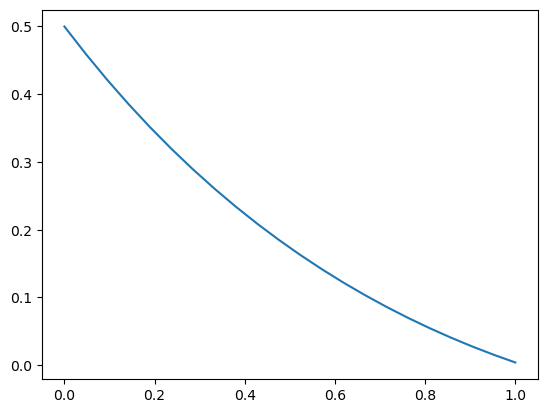

In [10]:
t_list = [i*5000 for i in range(22)]
circ_list = []
n_list = []
for i, t in enumerate(t_list):
    circ = QuantumCircuit(2)
    circ.h(0)
    circ.h(1)
    circ.cz(0, 1)
    circ.delay(t)

    circ.save_density_matrix()
    data = execute(circ, backend=backend, noise_model=noise_model).result().data()
    rho = data.get('density_matrix')
    n_list.append(calc_n(rho))
    
t_max = t_list[-1]
t_list = [t/t_max for t in t_list]
#n_list = [n*2 for n in n_list]
plt.plot(t_list, n_list)

In [11]:
from scipy.optimize import curve_fit
from scipy.stats import linregress

def decay0(t, a, b, c):
    return a*np.exp(-b*t) + c*t

def decay1(t, a, b, c, d):
    return a*np.exp(-b*t) + c*t + d

def decay_exp(t, a, b):
    return a * np.exp(-b * t)

def decay_lin(t, m, c):
    return -m*t + c

In [14]:
Xfit = np.linspace(t_list[0], t_list[-1], 100)

popt0, pcov0 = curve_fit(decay0, t_list, n_list)
popt1, pcov1 = curve_fit(decay1, t_list, n_list)
popt_exp, pcov_exp = curve_fit(decay_exp, t_list, n_list)
popt_lin, pcov_lin = curve_fit(decay_lin, t_list, n_list)

Yfit0 = decay0(Xfit, *popt0)
Yfit1 = decay1(Xfit, *popt1)
Yfit_exp = decay_exp(Xfit, *popt_exp)
Yfit_lin = decay_lin(Xfit, *popt_lin)

print(popt0)
print(popt1)
print(popt_exp)
print(popt_lin)

[ 0.50204359  1.62854416 -0.09708965]
[ 0.87933386  1.09881786  0.0902671  -0.37945783]
[0.53060841 2.38870201]
[0.48613432 0.44480934]


Text(0, 0.5, 'Negativity')

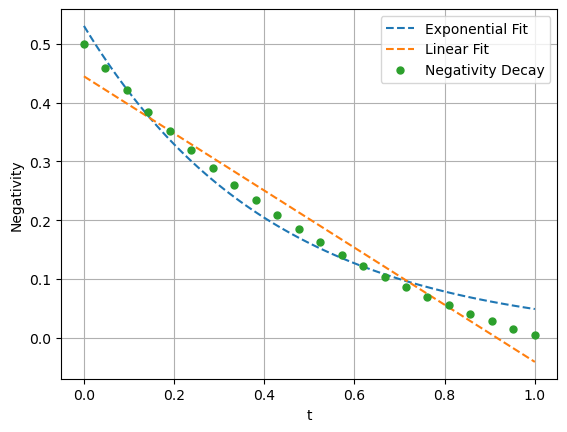

In [16]:
#plt.plot(Xfit, Yfit0, label='Exponential + Linear Fit (No y-intercept)', ls='--')
#plt.plot(Xfit, Yfit1, label='Exponential + Linear Fit', ls='--')
plt.plot(Xfit, Yfit_exp, label='Exponential Fit', ls='--')
plt.plot(Xfit, Yfit_lin, label='Linear Fit', ls='--')
plt.plot(t_list, n_list, label='Negativity Decay', marker='o', markersize=5, ls='')
plt.grid()
plt.legend()
plt.xlabel('t')
plt.ylabel('Negativity')

Text(0, 0.5, 'Negativity')

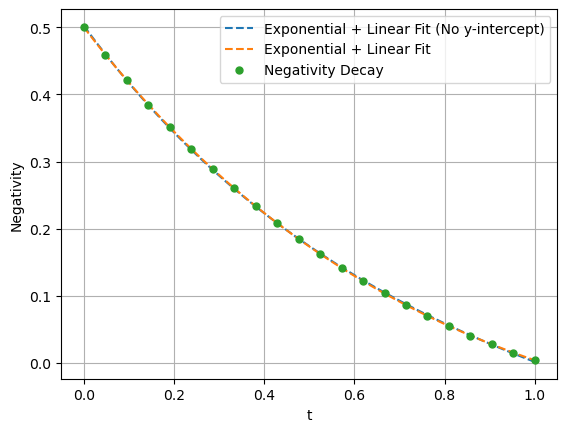

In [18]:
plt.plot(Xfit, Yfit0, label='Exponential + Linear Fit (No y-intercept)', ls='--')
plt.plot(Xfit, Yfit1, label='Exponential + Linear Fit', ls='--')
#plt.plot(Xfit, Yfit_exp, label='Exponential Fit', ls='--')
#plt.plot(Xfit, Yfit_lin, label='Linear Fit', ls='--')
plt.plot(t_list, n_list, label='Negativity Decay', marker='o', markersize=5, ls='')
plt.grid()
plt.legend()
plt.xlabel('t')
plt.ylabel('Negativity')

#### Device

In [4]:
backend = provider.get_backend('ibm_auckland')
step=3
#delays0 = [None, 3, 6, 9, 12, 15, 18]
delays = [None, 3, 6, 9, 12, 15, 18]

#n_lists = [n_list1, n_list2, n_list3, n_list4, n_list5, n_list6, n_list7, n_list8, n_list9]
#nmit_lists = [nmit_list1, nmit_list2, nmit_list3, nmit_list4, nmit_list5, nmit_list6, nmit_list7, nmit_list8, nmit_list9]

#### Free Decays

In [203]:
#backend = provider.get_backend('ibm_cairo')
graphstate = GraphState(backend)

In [204]:
shots = 2048
dd = None

In [205]:
job1 = graphstate.run_qst(reps=1, shots=shots, delay=None, dd=dd, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=1, shots=shots, delay=delays[1], dd=dd, qrem=True, execute_only=True)
job3 = graphstate.run_qst(reps=1, shots=shots, delay=delays[2], dd=dd, qrem=True, execute_only=True)
job4 = graphstate.run_qst(reps=1, shots=shots, delay=delays[3], dd=dd, qrem=True, execute_only=True)
job5 = graphstate.run_qst(reps=1, shots=shots, delay=delays[4], dd=dd, qrem=True, execute_only=True)
job6 = graphstate.run_qst(reps=1, shots=shots, delay=delays[5], dd=dd, qrem=True, execute_only=True)
job7 = graphstate.run_qst(reps=1, shots=shots, delay=delays[6], dd=dd, qrem=True, execute_only=True)
#job8 = graphstate.run_qst(reps=1, shots=shots, delay=14, dd=dd, qrem=True, execute_only=True)
#job9 = graphstate.run_qst(reps=1, shots=shots, delay=16, dd=dd, qrem=True, execute_only=True)
#job10 = graphstate.run_qst(reps=1, shots=shots, delay=9, dd=dd, qrem=True, execute_only=True)
#job11 = graphstate.run_qst(reps=1, shots=shots, delay=10, dd=dd, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
list_retrieve_jobs([job1.job_id(), job2.job_id(), job3.job_id(), job4.job_id(), job5.job_id(), job6.job_id(), job7.job_id()])
#print("Job 1 ID:", job1.job_id())
#print("Job 2 ID:", job2.job_id())
#print("Job 3 ID:", job3.job_id())
#print("Job 4 ID:", job4.job_id())
#print("Job 5 ID:", job5.job_id())
#print("Job 6 ID:", job6.job_id())
#print("Job 7 ID:", job7.job_id())
#print("Job 8 ID:", job8.job_id())
#print("Job 9 ID:", job9.job_id())
#print("Job 10 ID:", job10.job_id())
#print("Job 11 ID:", job11.job_id())

Device: ibm_auckland (27 qubits)
job1 = backend.retrieve_job('643ffe30101f264c9aec9d98')
job2 = backend.retrieve_job('643ffe37821d4c058ddb8b9b')
job3 = backend.retrieve_job('643ffe3c522e6a14ceea8cad')
job4 = backend.retrieve_job('643ffe42522e6a1afeea8cae')
job5 = backend.retrieve_job('643ffe48101f2659afec9d99')
job6 = backend.retrieve_job('643ffe4d4650265897e36f6e')
job7 = backend.retrieve_job('643ffe59821d4cc73fdb8b9c')


In [5]:
#backend = provider.get_backend('ibm_cairo')
graphstate = GraphState(backend)

job1 = provider.backend.retrieve_job('643ffe30101f264c9aec9d98')
job2 = provider.backend.retrieve_job('643ffe37821d4c058ddb8b9b')
job3 = provider.backend.retrieve_job('643ffe3c522e6a14ceea8cad')
job4 = provider.backend.retrieve_job('643ffe42522e6a1afeea8cae')
job5 = provider.backend.retrieve_job('643ffe48101f2659afec9d99')
job6 = provider.backend.retrieve_job('643ffe4d4650265897e36f6e')
job7 = provider.backend.retrieve_job('643ffe59821d4cc73fdb8b9c')

#backend = provider.get_backend('ibmq_montreal')
#graphstate = GraphState(backend)

#job1 = provider.backend.retrieve_job('6424e36a992f6092dab9d926')
#job2 = provider.backend.retrieve_job('6424e376d1309683a372869b')
#job3 = provider.backend.retrieve_job('6424e37ffd51ba3cfc12dcf1')
#job4 = provider.backend.retrieve_job('6424e389aa905e97934aacc6')
#job5 = provider.backend.retrieve_job('6424e3922937660ee96316ff')
#job6 = provider.backend.retrieve_job('6424e39c13be5d5fbb94eb33')
#job7 = provider.backend.retrieve_job('6424e3a5aa905e27194aacc7')
#job8 = provider.backend.retrieve_job('6424e3ae13be5d08a094eb34')
#job9 = provider.backend.retrieve_job('6424e3b8d13096520f7286a0')
#job10 = provider.backend.retrieve_job('6424e3c1992f60ab23b9d929')
#job11 = provider.backend.retrieve_job('6424e3caaa905e2d0e4aacc9')

In [6]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
#rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
#rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')
#rho_dict_mit10, rho_dict10 = graphstate.qst_from_result(job10.result(), 'all')
#rho_dict_mit11, rho_dict11 = graphstate.qst_from_result(job11.result(), 'all')

n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list3 = calc_negativities(rho_dict3, mode='mean')
nmit_list3 = calc_negativities(rho_dict_mit3, mode='mean')
n_list4 = calc_negativities(rho_dict4, mode='mean')
nmit_list4 = calc_negativities(rho_dict_mit4, mode='mean')
n_list5 = calc_negativities(rho_dict5, mode='mean')
nmit_list5 = calc_negativities(rho_dict_mit5, mode='mean')
n_list6 = calc_negativities(rho_dict6, mode='mean')
nmit_list6 = calc_negativities(rho_dict_mit6, mode='mean')
n_list7 = calc_negativities(rho_dict7, mode='mean')
nmit_list7 = calc_negativities(rho_dict_mit7, mode='mean')
#n_list8 = calc_negativities(rho_dict8, mode='mean')
#nmit_list8 = calc_negativities(rho_dict_mit8, mode='mean')
#n_list9 = calc_negativities(rho_dict9, mode='mean')
#nmit_list9 = calc_negativities(rho_dict_mit9, mode='mean')
#n_list10 = calc_negativities(rho_dict10, mode='mean')
#nmit_list10 = calc_negativities(rho_dict_mit10, mode='mean')
#n_list11 = calc_negativities(rho_dict11, mode='mean')
#nmit_list11 = calc_negativities(rho_dict_mit11, mode='mean')

time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')
#info_dict = get_negativity_info(n_list1, nmit_list1)
#m, s = get_mean_cnot(graphstate, job1.properties())

#info_dict

Time elapsed: 136.65 s


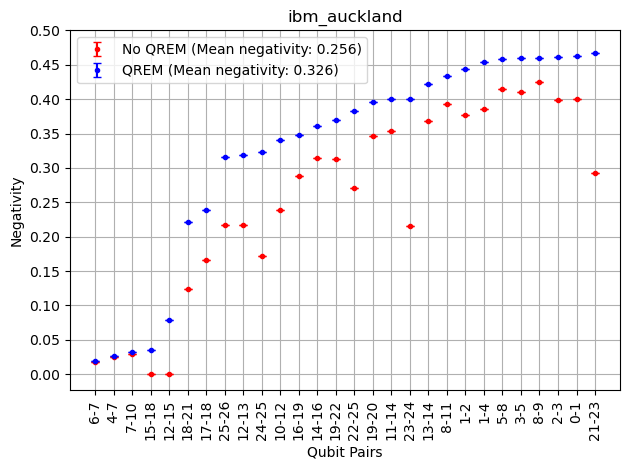

In [7]:
fig1, idx1 = plot_negativities_multi(backend, n_list1, nmit_list1, return_idx=True)

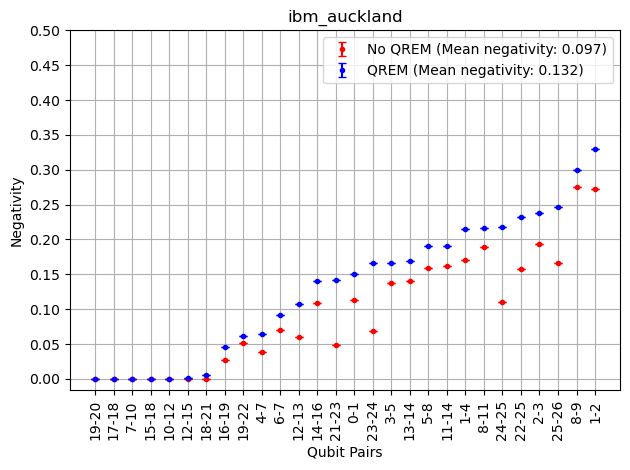

In [8]:
fig2, idx2 = plot_negativities_multi(backend, n_list2, nmit_list2, return_idx=True)

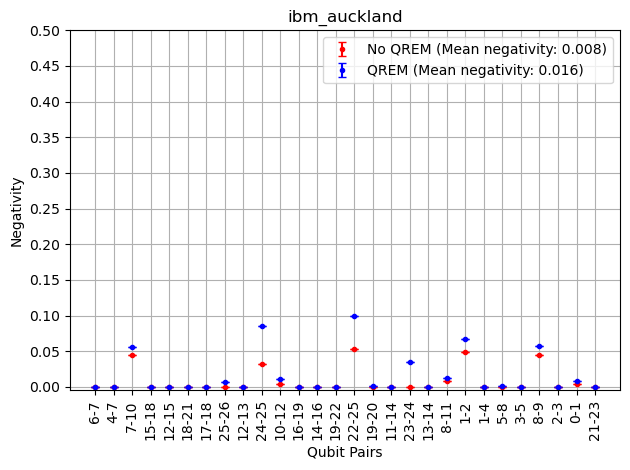

In [9]:
fig3 = plot_negativities_multi(backend, n_list3, nmit_list3, idx=idx1)

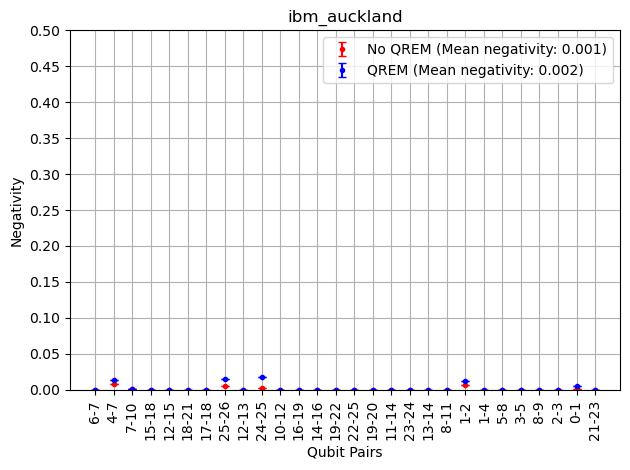

In [10]:
fig4 = plot_negativities_multi(backend, n_list4, nmit_list4, idx=idx1)

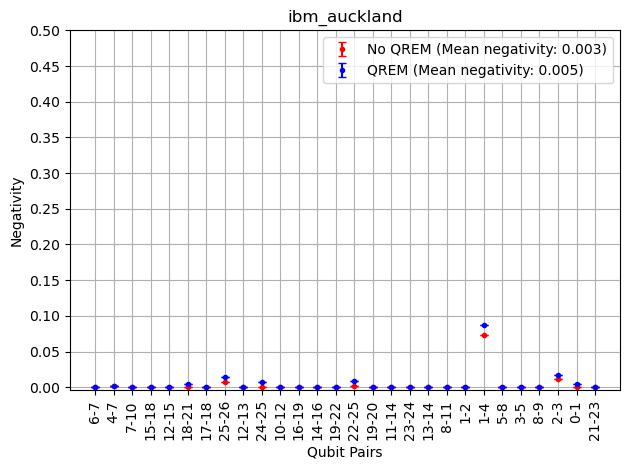

In [11]:
fig5 = plot_negativities_multi(backend, n_list5, nmit_list5, idx=idx1)

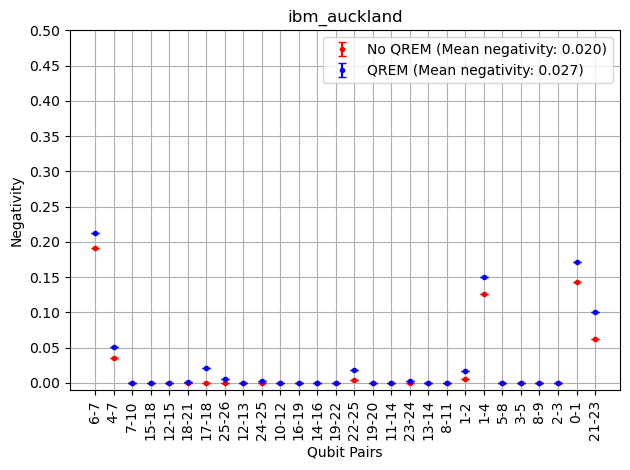

In [12]:
fig6 = plot_negativities_multi(backend, n_list6, nmit_list6, idx=idx1)

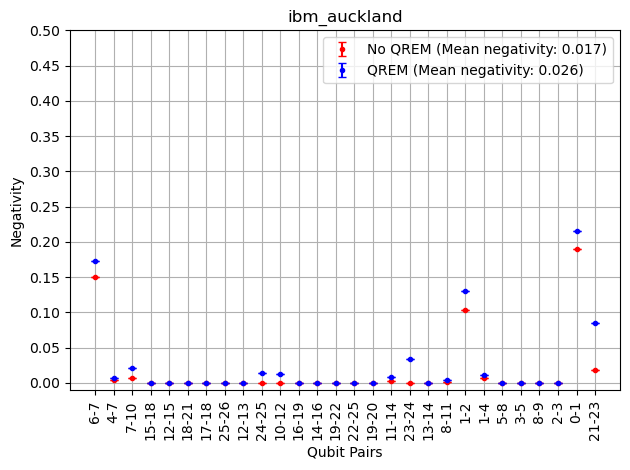

In [13]:
fig7 = plot_negativities_multi(backend, n_list7, nmit_list7, idx=idx1)

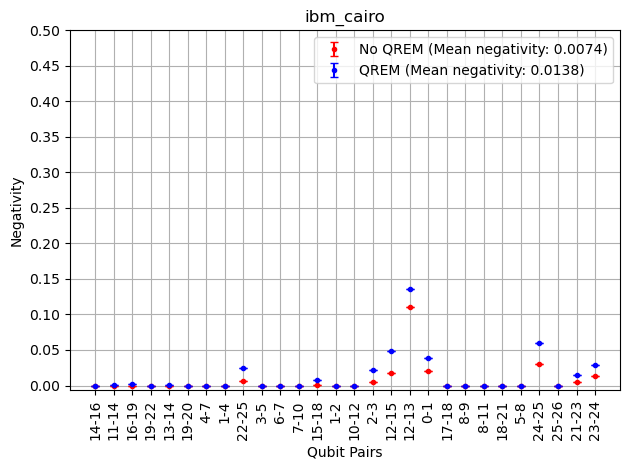

In [91]:
fig8 = plot_negativities_multi(backend, n_list8, nmit_list8, idx=idx1)

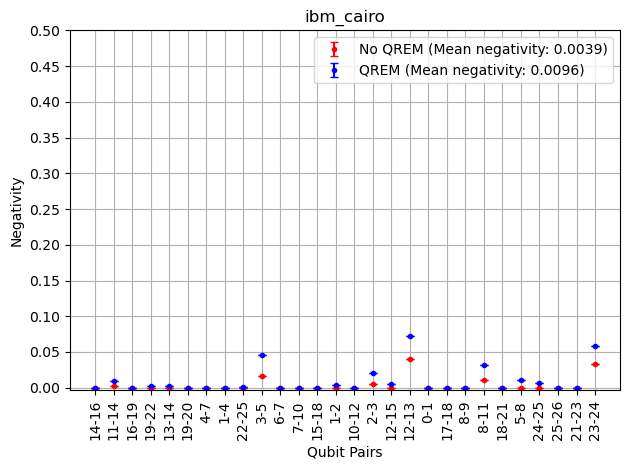

In [92]:
fig9 = plot_negativities_multi(backend, n_list9, nmit_list9, idx=idx1)

In [ ]:
fig10 = plot_negativities_multi(backend, n_list10, nmit_list10, idx=idx1)

In [ ]:
fig11 = plot_negativities_multi(backend, n_list11, nmit_list11, idx=idx1)

In [14]:
n_lists = [n_list1, n_list2, n_list3, n_list4, n_list5, n_list6, n_list7]
nmit_lists = [nmit_list1, nmit_list2, nmit_list3, nmit_list4, nmit_list5, nmit_list6, nmit_list7]

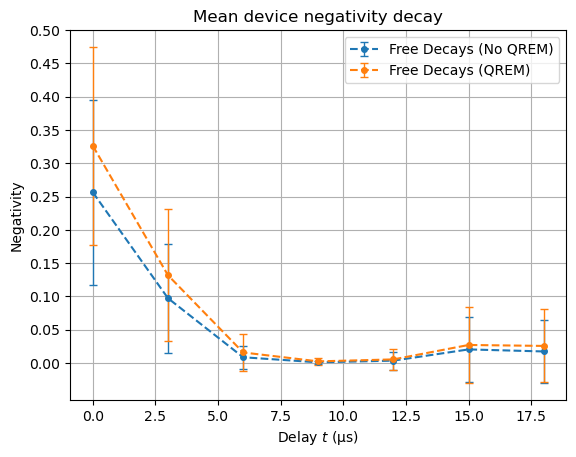

In [15]:
fig = plot_ndecays(n_lists, edges='mean', step=step, label='Free Decays (No QREM)')
fig = plot_ndecays(nmit_lists, edges='mean', step=step, label='Free Decays (QREM)', fig=fig)

#### Hahn Echo

In [206]:
#backend = provider.get_backend('ibm_cairo')
graphstate = GraphState(backend)

In [207]:
shots = 2048
dd = 'hahn'
#pulserate=8

In [208]:
job1 = graphstate.run_qst(reps=1, shots=shots, delay=None, dd=dd, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=1, shots=shots, delay=delays[1], dd=dd, qrem=True, execute_only=True)
job3 = graphstate.run_qst(reps=1, shots=shots, delay=delays[2], dd=dd, qrem=True, execute_only=True)
job4 = graphstate.run_qst(reps=1, shots=shots, delay=delays[3], dd=dd, qrem=True, execute_only=True)
job5 = graphstate.run_qst(reps=1, shots=shots, delay=delays[4], dd=dd, qrem=True, execute_only=True)
job6 = graphstate.run_qst(reps=1, shots=shots, delay=delays[5], dd=dd, qrem=True, execute_only=True)
job7 = graphstate.run_qst(reps=1, shots=shots, delay=delays[6], dd=dd, qrem=True, execute_only=True)
#job8 = graphstate.run_qst(reps=1, shots=shots, delay=14, dd=dd, qrem=True, execute_only=True)
#job9 = graphstate.run_qst(reps=1, shots=shots, delay=16, dd=dd, qrem=True, execute_only=True)
#job10 = graphstate.run_qst(reps=1, shots=shots, delay=9, dd=dd, qrem=True, execute_only=True)
#job11 = graphstate.run_qst(reps=1, shots=shots, delay=10, dd=dd, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
list_retrieve_jobs([job1.job_id(), job2.job_id(), job3.job_id(), job4.job_id(), job5.job_id(), job6.job_id(), job7.job_id()])
#print("Job 1 ID:", job1.job_id())
#print("Job 2 ID:", job2.job_id())
#print("Job 3 ID:", job3.job_id())
#print("Job 4 ID:", job4.job_id())
#print("Job 5 ID:", job5.job_id())
#print("Job 6 ID:", job6.job_id())
#print("Job 7 ID:", job7.job_id())
#print("Job 8 ID:", job8.job_id())
#print("Job 9 ID:", job9.job_id())
#print("Job 10 ID:", job10.job_id())
#print("Job 11 ID:", job11.job_id())

Device: ibm_auckland (27 qubits)
job1 = backend.retrieve_job('643ffe718dae913696aafc4d')
job2 = backend.retrieve_job('643ffe79821d4ca156db8b9d')
job3 = backend.retrieve_job('643ffe814650266db7e36f6f')
job4 = backend.retrieve_job('643ffe89492715f6d3308216')
job5 = backend.retrieve_job('643ffe8f371eea5322c5bd13')
job6 = backend.retrieve_job('643ffe9649271518fe308217')
job7 = backend.retrieve_job('643ffe9d49271527eb308218')


In [16]:
#backend = provider.get_backend('ibm_cairo')
graphstate = GraphState(backend)

job1 = provider.backend.retrieve_job('643ffe718dae913696aafc4d')
job2 = provider.backend.retrieve_job('643ffe79821d4ca156db8b9d')
job3 = provider.backend.retrieve_job('643ffe814650266db7e36f6f')
job4 = provider.backend.retrieve_job('643ffe89492715f6d3308216')
job5 = provider.backend.retrieve_job('643ffe8f371eea5322c5bd13')
job6 = provider.backend.retrieve_job('643ffe9649271518fe308217')
job7 = provider.backend.retrieve_job('643ffe9d49271527eb308218')

#job1 = provider.backend.retrieve_job('6424ed5f1e787ac9151a1efe')
#job2 = provider.backend.retrieve_job('6424ed69992f6022f6b9d95c')
#job3 = provider.backend.retrieve_job('6424ed7530473c4314ede1c1')
#job4 = provider.backend.retrieve_job('6424ed801e787af19d1a1eff')
#job5 = provider.backend.retrieve_job('6424ed8cd13096e3e47286cc')
#job6 = provider.backend.retrieve_job('6424ed97aa905e9b584aacf5')
#job7 = provider.backend.retrieve_job('6424eda3472d122487803649')
#job8 = provider.backend.retrieve_job('6424edaeaa905ee6934aacf6')
#job9 = provider.backend.retrieve_job('6424edb91e787a20991a1f00')
#job10 = provider.backend.retrieve_job('6424edc530473c8437ede1c2')
#job11 = provider.backend.retrieve_job('6424edd0aa905e23994aacf7')

In [17]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
#rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
#rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')
#rho_dict_mit10, rho_dict10 = graphstate.qst_from_result(job10.result(), 'all')
#rho_dict_mit11, rho_dict11 = graphstate.qst_from_result(job11.result(), 'all')

n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list3 = calc_negativities(rho_dict3, mode='mean')
nmit_list3 = calc_negativities(rho_dict_mit3, mode='mean')
n_list4 = calc_negativities(rho_dict4, mode='mean')
nmit_list4 = calc_negativities(rho_dict_mit4, mode='mean')
n_list5 = calc_negativities(rho_dict5, mode='mean')
nmit_list5 = calc_negativities(rho_dict_mit5, mode='mean')
n_list6 = calc_negativities(rho_dict6, mode='mean')
nmit_list6 = calc_negativities(rho_dict_mit6, mode='mean')
n_list7 = calc_negativities(rho_dict7, mode='mean')
nmit_list7 = calc_negativities(rho_dict_mit7, mode='mean')
#n_list8 = calc_negativities(rho_dict8, mode='mean')
#nmit_list8 = calc_negativities(rho_dict_mit8, mode='mean')
#n_list9 = calc_negativities(rho_dict9, mode='mean')
#nmit_list9 = calc_negativities(rho_dict_mit9, mode='mean')
#n_list10 = calc_negativities(rho_dict10, mode='mean')
#nmit_list10 = calc_negativities(rho_dict_mit10, mode='mean')
#n_list11 = calc_negativities(rho_dict11, mode='mean')
#nmit_list11 = calc_negativities(rho_dict_mit11, mode='mean')

time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 116.16 s


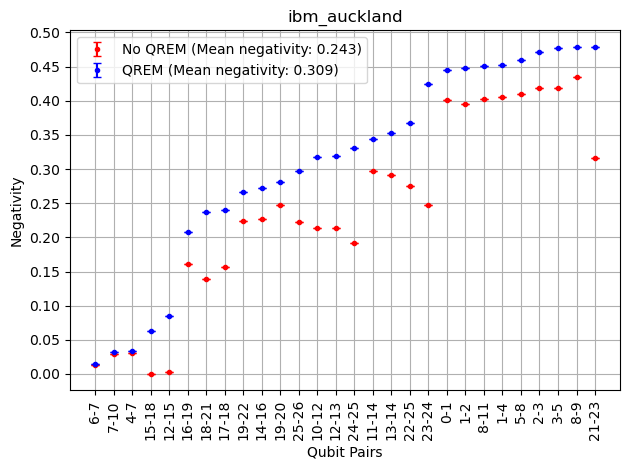

In [18]:
fig1, idx1 = plot_negativities_multi(backend, n_list1, nmit_list1, return_idx=True)

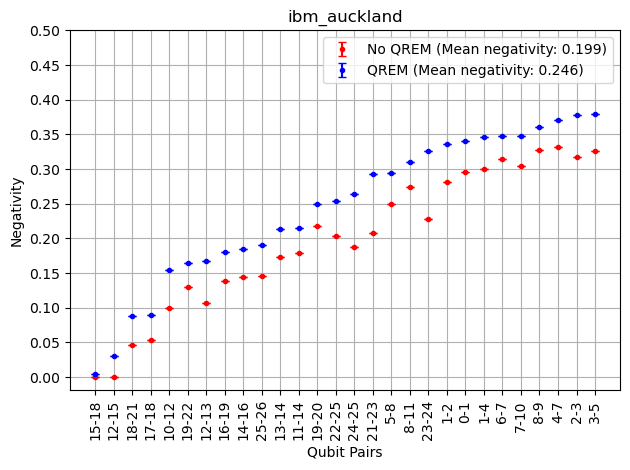

In [19]:
fig2, idx2 = plot_negativities_multi(backend, n_list2, nmit_list2, return_idx=True)

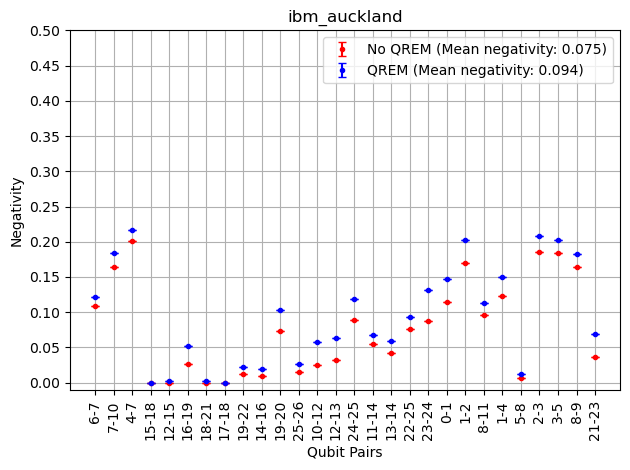

In [20]:
fig3 = plot_negativities_multi(backend, n_list3, nmit_list3, idx=idx1)

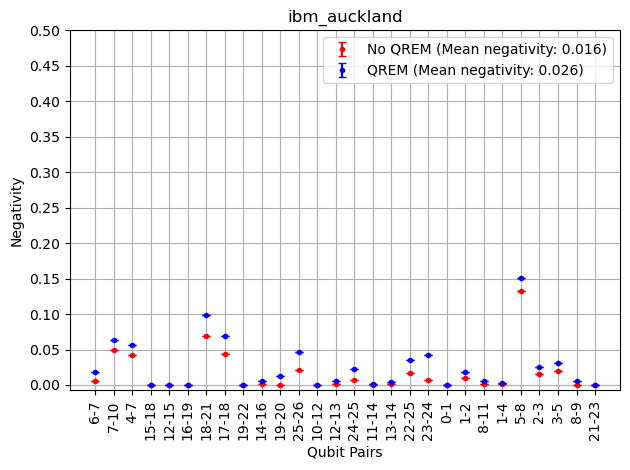

In [21]:
fig4 = plot_negativities_multi(backend, n_list4, nmit_list4, idx=idx1)

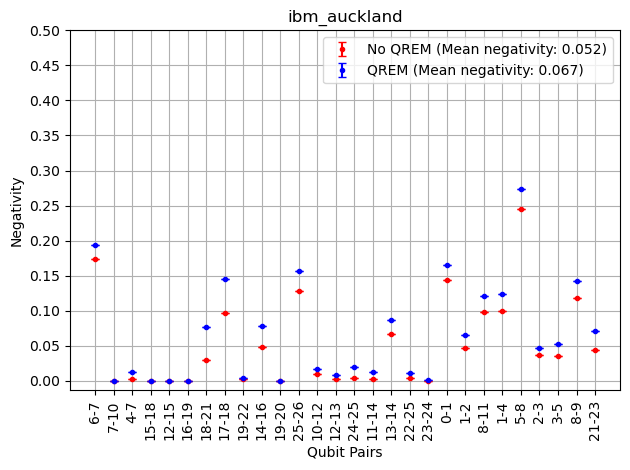

In [22]:
fig5 = plot_negativities_multi(backend, n_list5, nmit_list5, idx=idx1)

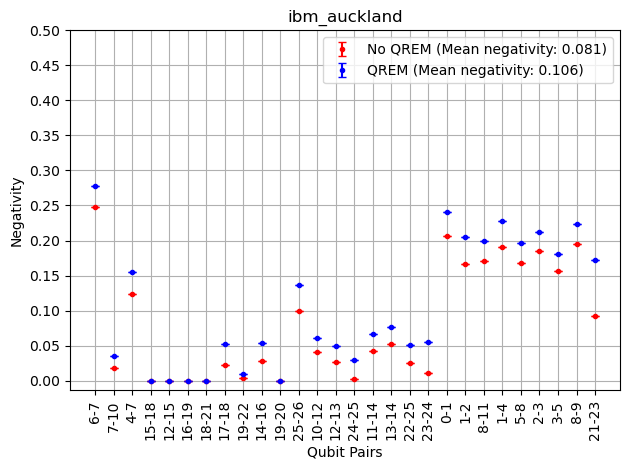

In [23]:
fig6 = plot_negativities_multi(backend, n_list6, nmit_list6, idx=idx1)

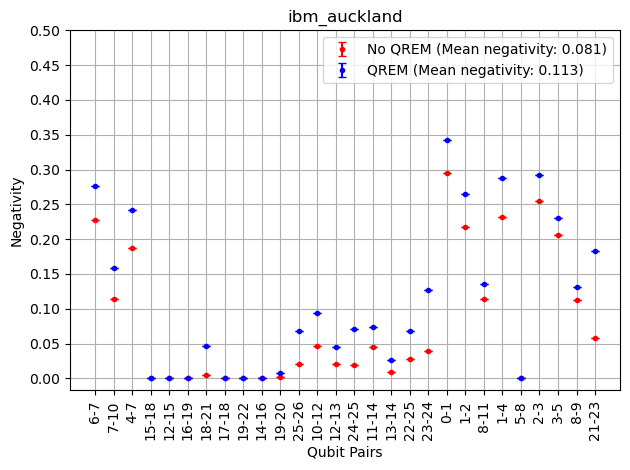

In [24]:
fig7 = plot_negativities_multi(backend, n_list7, nmit_list7, idx=idx1)

In [ ]:
fig8 = plot_negativities_multi(backend, n_list8, nmit_list8, idx=idx1)

In [ ]:
fig9 = plot_negativities_multi(backend, n_list9, nmit_list9, idx=idx1)

In [ ]:
fig10 = plot_negativities_multi(backend, n_list10, nmit_list10, idx=idx1)

In [ ]:
fig11 = plot_negativities_multi(backend, n_list11, nmit_list11, idx=idx1)

In [25]:
n_lists_hahn = [n_list1, n_list2, n_list3, n_list4, n_list5, n_list6, n_list7]
nmit_lists_hahn = [nmit_list1, nmit_list2, nmit_list3, nmit_list4, nmit_list5, nmit_list6, nmit_list7]

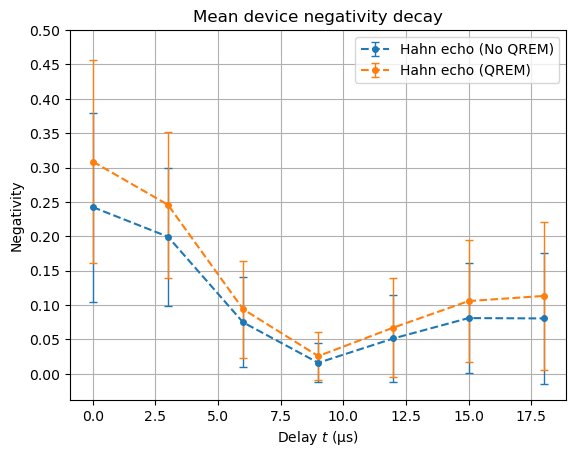

In [26]:
fig = plot_ndecays(n_lists_hahn, edges='mean', step=step, label='Hahn echo (No QREM)')
fig = plot_ndecays(nmit_lists_hahn, edges='mean', step=step, label='Hahn echo (QREM)', fig=fig)

#### PDD

In [209]:
#backend = provider.get_backend('ibm_cairo')
graphstate = GraphState(backend)

In [210]:
shots = 2048
dd = 'pdd'
pulserate=8

In [ ]:
job1 = graphstate.run_qst(reps=1, shots=shots, delay=None, dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=1, shots=shots, delay=delays[1], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job3 = graphstate.run_qst(reps=1, shots=shots, delay=delays[2], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job4 = graphstate.run_qst(reps=1, shots=shots, delay=delays[3], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job5 = graphstate.run_qst(reps=1, shots=shots, delay=delays[4], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job6 = graphstate.run_qst(reps=1, shots=shots, delay=delays[5], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job7 = graphstate.run_qst(reps=1, shots=shots, delay=delays[6], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
#job8 = graphstate.run_qst(reps=1, shots=shots, delay=14, dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
#job9 = graphstate.run_qst(reps=1, shots=shots, delay=16, dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
#job10 = graphstate.run_qst(reps=1, shots=shots, delay=9, dd=dd, qrem=True, execute_only=True)
#job11 = graphstate.run_qst(reps=1, shots=shots, delay=10, dd=dd, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
list_retrieve_jobs([job1.job_id(), job2.job_id(), job3.job_id(), job4.job_id(), job5.job_id(), job6.job_id(), job7.job_id()])
#print("Job 1 ID:", job1.job_id())
#print("Job 2 ID:", job2.job_id())
#print("Job 3 ID:", job3.job_id())
#print("Job 4 ID:", job4.job_id())
#print("Job 5 ID:", job5.job_id())
#print("Job 6 ID:", job6.job_id())
#print("Job 7 ID:", job7.job_id())
#print("Job 8 ID:", job8.job_id())
#print("Job 9 ID:", job9.job_id())
#print("Job 10 ID:", job10.job_id())
#print("Job 11 ID:", job11.job_id())

In [27]:
#backend = provider.get_backend('ibm_cairo')
graphstate = GraphState(backend)

job1 = provider.backend.retrieve_job('643fe5bf101f26297dec9d76')
job2 = provider.backend.retrieve_job('643fe5d8371eea5adfc5bcf9')
job3 = provider.backend.retrieve_job('643fe608febe64628a94cc3e')
job4 = provider.backend.retrieve_job('643fe66e4650260cc8e36f51')
job5 = provider.backend.retrieve_job('643fe76efebe6421fa94cc40')
job6 = provider.backend.retrieve_job('643fe868465026947de36f55')
job7 = provider.backend.retrieve_job('643fe9b0371eea7a75c5bd03')

#backend = provider.get_backend('ibmq_montreal')
#graphstate = GraphState(backend)

#job1 = provider.backend.retrieve_job('6424d49dc366f637c4c590a4')
#job2 = provider.backend.retrieve_job('6424d4bed13096542b728626')
#job3 = provider.backend.retrieve_job('6424d516c366f60155c590a7')
#job4 = provider.backend.retrieve_job('6424d58729376600bb6316b1')
#job5 = provider.backend.retrieve_job('6424d6bfaa905e733e4aac7b')
#job6 = provider.backend.retrieve_job('6424d858992f601334b9d8d4')
#job7 = provider.backend.retrieve_job('6424d98f472d12430a8035d2')
#job8 = provider.backend.retrieve_job('6424db4b293766ebb56316d5')
#job9 = provider.backend.retrieve_job('6424dbf513be5d7c9994eafd')
#job10 = provider.backend.retrieve_job('6424dc981e787a4f491a1e98')
#job11 = provider.backend.retrieve_job('6424dd511e787a2fca1a1e9e')

C:\Users\jfide\anaconda3\envs\qc-env\lib\site-packages\qiskit\providers\ibmq\ibmqbackend.py:691: UserWarning: Job 643fe5bf101f26297dec9d76 belongs to another backend than the one queried. The query was made on backend ibm_auckland, but the job actually belongs to backend ibm_cairo.
  warnings.warn('Job {} belongs to another backend than the one queried. '


IBMQBackendError: 'Failed to get job 643fe5bf101f26297dec9d76: job does not belong to backend ibm_auckland.'

In [ ]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
#rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
#rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')
#rho_dict_mit10, rho_dict10 = graphstate.qst_from_result(job10.result(), 'all')
#rho_dict_mit11, rho_dict11 = graphstate.qst_from_result(job11.result(), 'all')

n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list3 = calc_negativities(rho_dict3, mode='mean')
nmit_list3 = calc_negativities(rho_dict_mit3, mode='mean')
n_list4 = calc_negativities(rho_dict4, mode='mean')
nmit_list4 = calc_negativities(rho_dict_mit4, mode='mean')
n_list5 = calc_negativities(rho_dict5, mode='mean')
nmit_list5 = calc_negativities(rho_dict_mit5, mode='mean')
n_list6 = calc_negativities(rho_dict6, mode='mean')
nmit_list6 = calc_negativities(rho_dict_mit6, mode='mean')
n_list7 = calc_negativities(rho_dict7, mode='mean')
nmit_list7 = calc_negativities(rho_dict_mit7, mode='mean')
#n_list8 = calc_negativities(rho_dict8, mode='mean')
#nmit_list8 = calc_negativities(rho_dict_mit8, mode='mean')
#n_list9 = calc_negativities(rho_dict9, mode='mean')
#nmit_list9 = calc_negativities(rho_dict_mit9, mode='mean')
#n_list10 = calc_negativities(rho_dict10, mode='mean')
#nmit_list10 = calc_negativities(rho_dict_mit10, mode='mean')
#n_list11 = calc_negativities(rho_dict11, mode='mean')
#nmit_list11 = calc_negativities(rho_dict_mit11, mode='mean')

time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

In [ ]:
fig1, idx1 = plot_negativities_multi(backend, n_list1, nmit_list1, return_idx=True)

In [ ]:
fig2, idx2 = plot_negativities_multi(backend, n_list2, nmit_list2, idx=idx1, return_idx=True)

In [ ]:
fig3 = plot_negativities_multi(backend, n_list3, nmit_list3, idx=idx1)

In [ ]:
fig4 = plot_negativities_multi(backend, n_list4, nmit_list4, idx=idx1)

In [ ]:
fig5 = plot_negativities_multi(backend, n_list5, nmit_list5, idx=idx1)

In [ ]:
fig6 = plot_negativities_multi(backend, n_list6, nmit_list6, idx=idx1)

In [ ]:
fig7 = plot_negativities_multi(backend, n_list7, nmit_list7, idx=idx1)

In [ ]:
fig8 = plot_negativities_multi(backend, n_list8, nmit_list8, idx=idx1)

In [ ]:
fig9 = plot_negativities_multi(backend, n_list9, nmit_list9, idx=idx1)

In [ ]:
fig10 = plot_negativities_multi(backend, n_list10, nmit_list10, idx=idx1)

In [ ]:
fig11 = plot_negativities_multi(backend, n_list11, nmit_list11, idx=idx1)

In [ ]:
n_lists_pdd = [n_list1, n_list2, n_list3, n_list4, n_list5, n_list6, n_list7]
nmit_lists_pdd = [nmit_list1, nmit_list2, nmit_list3, nmit_list4, nmit_list5, nmit_list6, nmit_list7]

In [ ]:
fig = plot_ndecays(n_lists_pdd, edges='mean', step=step, label='PDD (No QREM)')
fig = plot_ndecays(nmit_lists_pdd, edges='mean', step=step, label='PDD (QREM)', fig=fig)

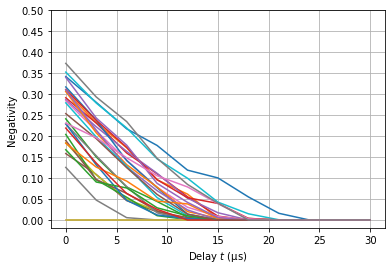

In [33]:
fig = plot_ndecays(n_lists_pdd, edges='all', step=step, label='PDD (No QREM)')
#fig = plot_ndecays(nmit_lists_pdd, edges='all', step=step, label='PDD (QREM)', fig=fig)

In [ ]:
fig = plot_ndecays(n_lists, edges='mean', step=step, label='Free Decays (No QREM)')
fig = plot_ndecays(n_lists_hahn, edges='mean', step=step, label='Hahn Echo (No QREM)', fig=fig)
#fig = plot_ndecays(n_lists_pdd, edges='mean', step=step, label='PDD (No QREM)', fig=fig)

In [ ]:
fig = plot_ndecays(nmit_lists, edges='mean', step=step, label='Free Decays (QREM)')
fig = plot_ndecays(nmit_lists_hahn, edges='mean', step=step, label='Hahn Echo (QREM)', fig=fig)
#fig = plot_ndecays(nmit_lists_pdd, edges='mean', step=step, label='PDD (QREM)', fig=fig)

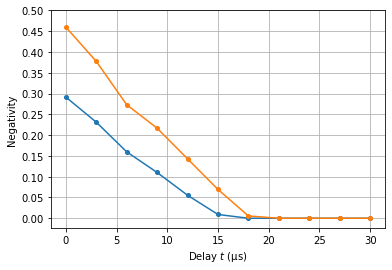

In [37]:
fig = plot_ndecays(n_lists_pdd, edges=(2, 3), step=step, label='No QREM (8-9)')
fig = plot_ndecays(nmit_lists_pdd, edges=(2, 3), step=step, label='QREM (8-9)', fig=fig)

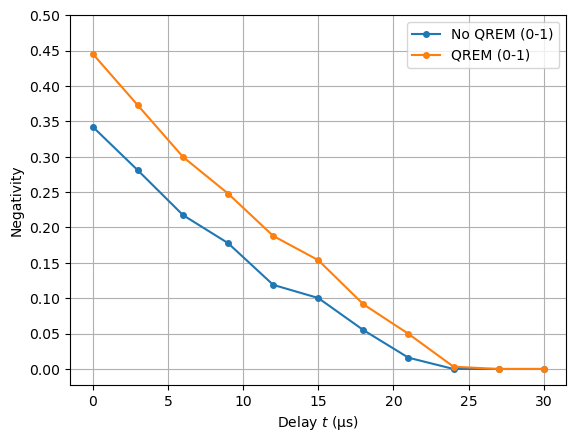

In [58]:
fig = plot_ndecays(n_lists, edges=(0, 1), step=step, label='No QREM (0-1)')
fig = plot_ndecays(nmit_lists, edges=(0, 1), step=step, label='QREM (0-1)', fig=fig)

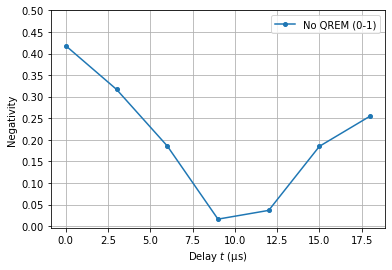

In [46]:
fig = plot_ndecays(n_lists_hahn, edges=(2, 3), step=step, label='No QREM (0-1)')

#### Hahn Echo (ibm_hanoi)

In [23]:
backend = provider.get_backend('ibm_hanoi')
graphstate = GraphState(backend)

In [24]:
shots = 2048
dd = 'hahn'

In [13]:
job1 = graphstate.run_qst(reps=1, shots=shots, delay=None, dd=dd, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=1, shots=shots, delay=3, dd=dd, qrem=True, execute_only=True)
job3 = graphstate.run_qst(reps=1, shots=shots, delay=6 dd=dd, qrem=True, execute_only=True)
job4 = graphstate.run_qst(reps=1, shots=shots, delay=9, dd=dd, qrem=True, execute_only=True)
job5 = graphstate.run_qst(reps=1, shots=shots, delay=12, dd=dd, qrem=True, execute_only=True)
job6 = graphstate.run_qst(reps=1, shots=shots, delay=15, dd=dd, qrem=True, execute_only=True)
job7 = graphstate.run_qst(reps=1, shots=shots, delay=18, dd=dd, qrem=True, execute_only=True)
job8 = graphstate.run_qst(reps=1, shots=shots, delay=21, dd=dd, qrem=True, execute_only=True)
job9 = graphstate.run_qst(reps=1, shots=shots, delay=24, dd=dd, qrem=True, execute_only=True)
job10 = graphstate.run_qst(reps=1, shots=shots, delay=27, dd=dd, qrem=True, execute_only=True)
job11 = graphstate.run_qst(reps=1, shots=shots, delay=30, dd=dd, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())
print("Job 3 ID:", job3.job_id())
print("Job 4 ID:", job4.job_id())
print("Job 5 ID:", job5.job_id())
print("Job 6 ID:", job6.job_id())
print("Job 7 ID:", job7.job_id())
print("Job 8 ID:", job8.job_id())
print("Job 9 ID:", job9.job_id())
print("Job 10 ID:", job10.job_id())
print("Job 11 ID:", job11.job_id())

Device: ibm_hanoi (27 qubits)
Job 1 ID: 64223d94c0534827f5d3da19
Job 2 ID: 64223d9ec0092c0ce29d21c6
Job 3 ID: 64223da6c0534816add3da1a
Job 4 ID: 64223db0e10f2b74ab5d64d8
Job 5 ID: 64223db85c50b31b0b7978e3
Job 6 ID: 64223dbf6f22154f681e9240
Job 7 ID: 64223dc66f22155c501e9241
Job 8 ID: 64223dcd2a1c7a05342f64a8
Job 9 ID: 64223dd4bb079d207361b9e2
Job 10 ID: 64223ddcc05348848bd3da1c
Job 11 ID: 64223de3c053485b2ad3da1d


In [3]:
backend = provider.get_backend('ibm_hanoi')
graphstate = GraphState(backend)

job1 = provider.backend.retrieve_job('')
job2 = provider.backend.retrieve_job('')
job3 = provider.backend.retrieve_job('')
job4 = provider.backend.retrieve_job('')
job5 = provider.backend.retrieve_job('')
job6 = provider.backend.retrieve_job('')
job7 = provider.backend.retrieve_job('')
job8 = provider.backend.retrieve_job('')
job9 = provider.backend.retrieve_job('')
job10 = provider.backend.retrieve_job('')
job11 = provider.backend.retrieve_job('')

In [4]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')
rho_dict_mit10, rho_dict10 = graphstate.qst_from_result(job10.result(), 'all')
rho_dict_mit11, rho_dict11 = graphstate.qst_from_result(job11.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 97.96 s


In [5]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list3 = calc_negativities(rho_dict3, mode='mean')
nmit_list3 = calc_negativities(rho_dict_mit3, mode='mean')
n_list4 = calc_negativities(rho_dict4, mode='mean')
nmit_list4 = calc_negativities(rho_dict_mit4, mode='mean')
n_list5 = calc_negativities(rho_dict5, mode='mean')
nmit_list5 = calc_negativities(rho_dict_mit5, mode='mean')
n_list6 = calc_negativities(rho_dict6, mode='mean')
nmit_list6 = calc_negativities(rho_dict_mit6, mode='mean')
n_list7 = calc_negativities(rho_dict7, mode='mean')
nmit_list7 = calc_negativities(rho_dict_mit7, mode='mean')
n_list8 = calc_negativities(rho_dict8, mode='mean')
nmit_list8 = calc_negativities(rho_dict_mit8, mode='mean')
n_list9 = calc_negativities(rho_dict9, mode='mean')
nmit_list9 = calc_negativities(rho_dict_mit9, mode='mean')
n_list10 = calc_negativities(rho_dict10, mode='mean')
nmit_list10 = calc_negativities(rho_dict_mit10, mode='mean')
n_list11 = calc_negativities(rho_dict11, mode='mean')
nmit_list11 = calc_negativities(rho_dict_mit11, mode='mean')

#info_dict = get_negativity_info(n_list1, nmit_list1)
#m, s = get_mean_cnot(graphstate, job1.properties())

#info_dict

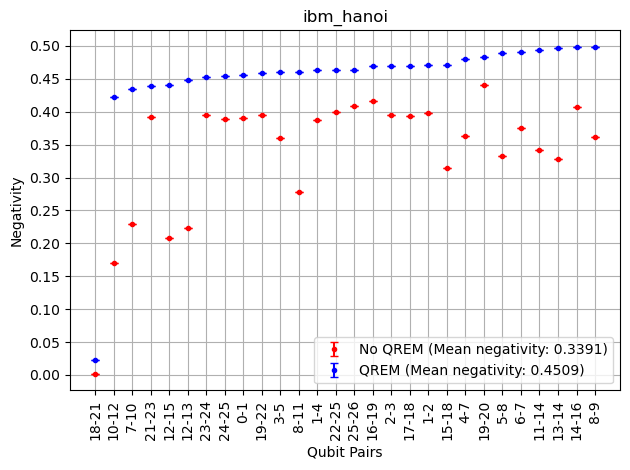

In [44]:
fig1, idx = plot_negativities_multi(backend, n_list1, nmit_list1, return_idx=True)

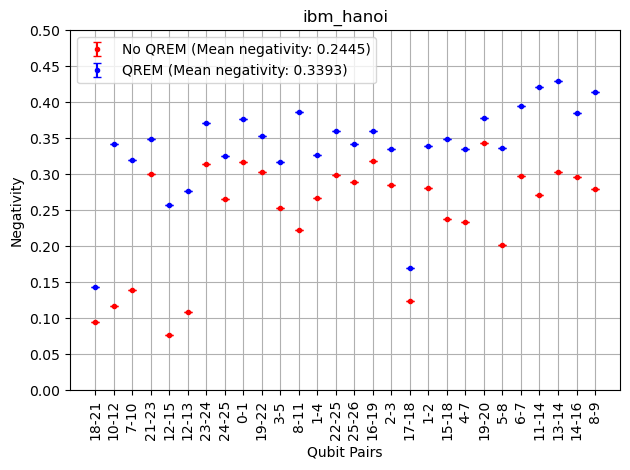

In [45]:
fig2 = plot_negativities_multi(backend, n_list2, nmit_list2, idx=idx)

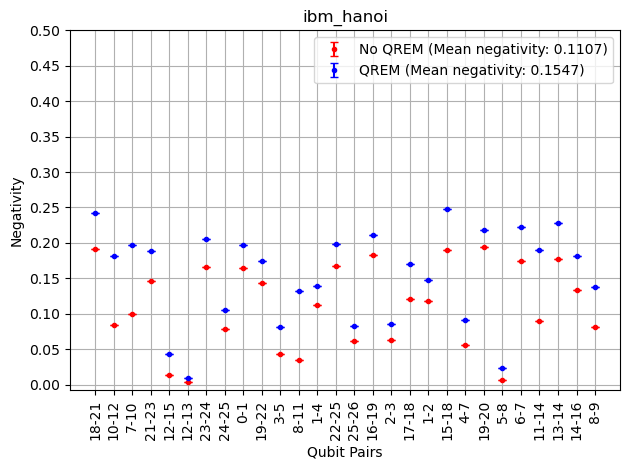

In [46]:
fig3 = plot_negativities_multi(backend, n_list3, nmit_list3, idx=idx)

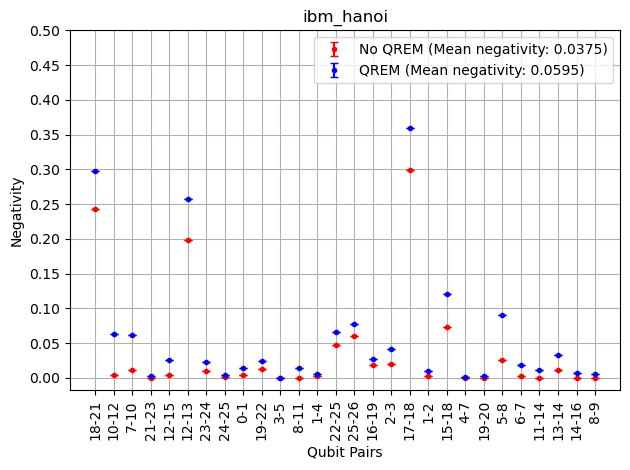

In [47]:
fig4 = plot_negativities_multi(backend, n_list4, nmit_list4, idx=idx)

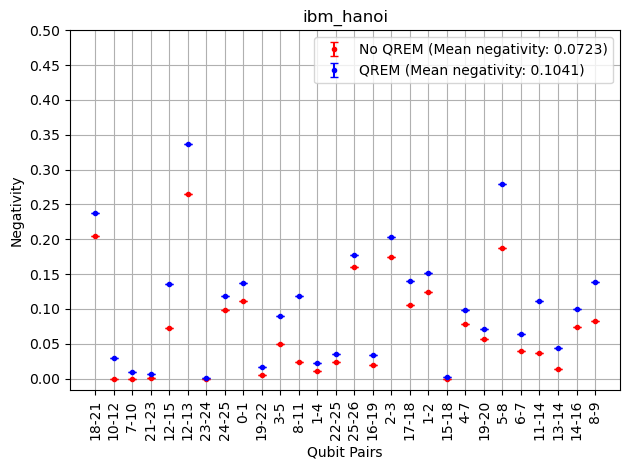

In [48]:
fig5 = plot_negativities_multi(backend, n_list5, nmit_list5, idx=idx)

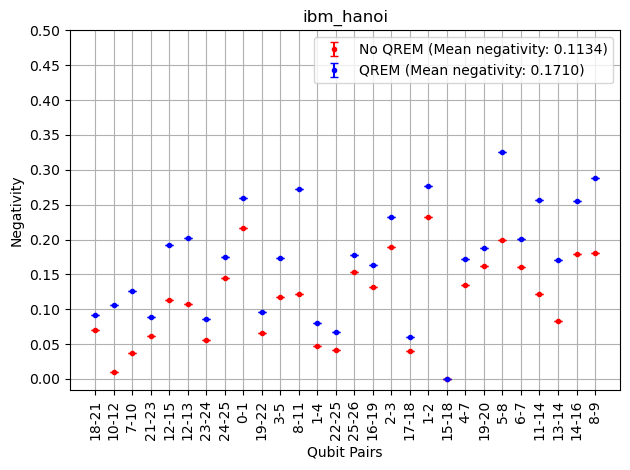

In [49]:
fig6 = plot_negativities_multi(backend, n_list6, nmit_list6, idx=idx)

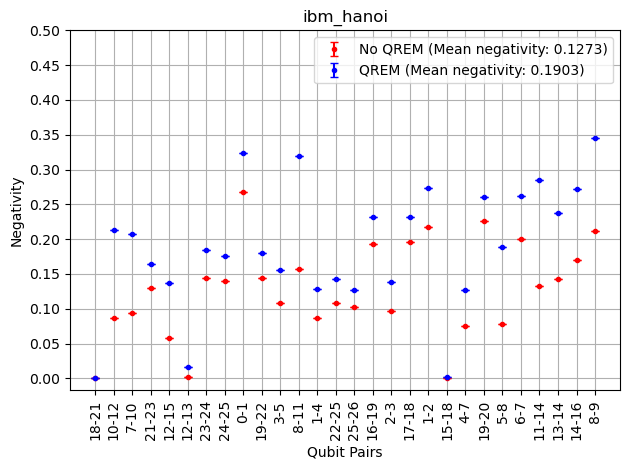

In [50]:
fig7 = plot_negativities_multi(backend, n_list7, nmit_list7, idx=idx)

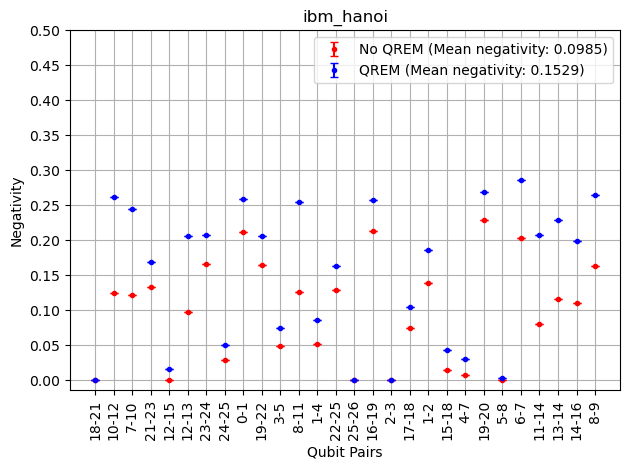

In [51]:
fig8 = plot_negativities_multi(backend, n_list8, nmit_list8, idx=idx)

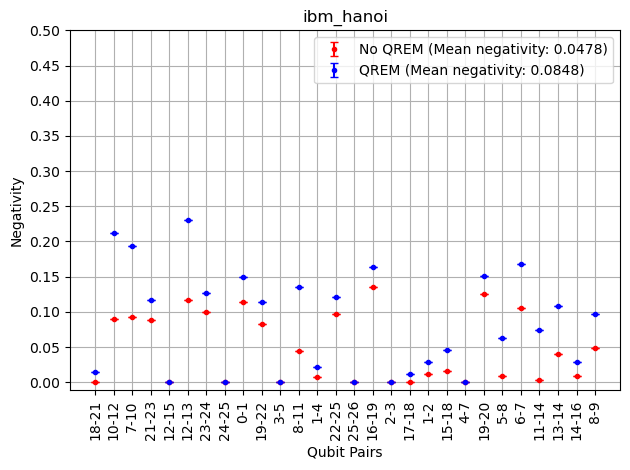

In [52]:
fig9 = plot_negativities_multi(backend, n_list9, nmit_list9, idx=idx)

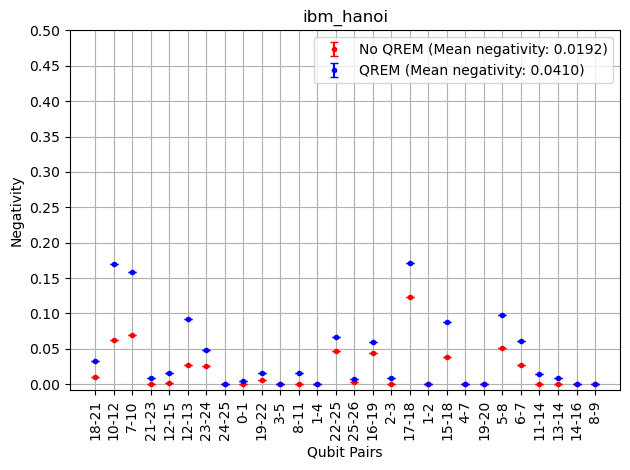

In [53]:
fig10 = plot_negativities_multi(backend, n_list10, nmit_list10, idx=idx)

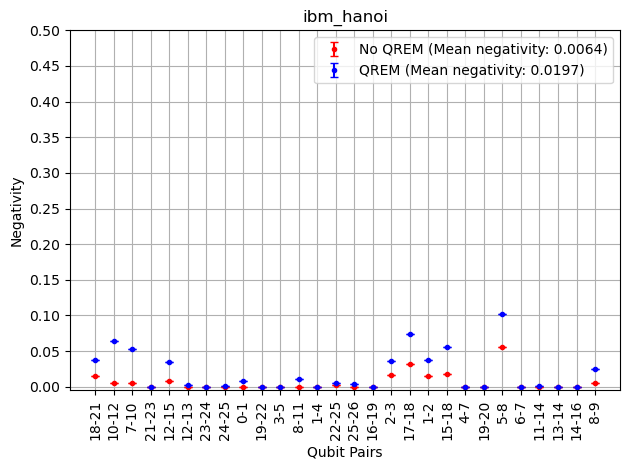

In [54]:
fig11 = plot_negativities_multi(backend, n_list11, nmit_list11, idx=idx)

In [146]:
n_lists = [n_list1, n_list2, n_list3, n_list4, n_list5, n_list6, n_list7, n_list8, n_list9, n_list10, n_list11]
nmit_lists = [nmit_list1, nmit_list2, nmit_list3, nmit_list4, nmit_list5, nmit_list6, nmit_list7, nmit_list8, nmit_list9, nmit_list10, nmit_list11]

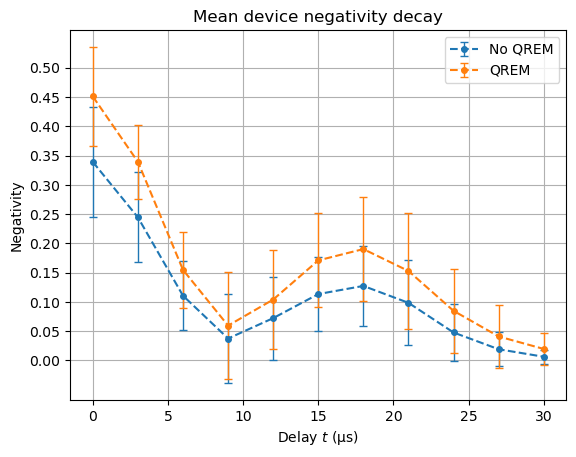

In [147]:
fig = plot_ndecays(n_lists, edges='mean', step=step, label='No QREM')
fig = plot_ndecays(nmit_lists, edges='mean', step=step, label='QREM', fig=fig)

### 127 Qubit Device

In [50]:
backend = provider.get_backend('ibm_brisbane')
graphstate = GraphState(backend)
shots = 2048

#delays = [None] + list(range(2, 22, 2))
step = 1
delays = [None] + [i*step for i in range(1, 11)]
print(delays)

[None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


#### Free decays

In [51]:
dd = None
pulserate = None

In [52]:
job1 = graphstate.run_qst(reps=1, shots=shots, delay=None, dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=1, shots=shots, delay=delays[1], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job3 = graphstate.run_qst(reps=1, shots=shots, delay=delays[2], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job4 = graphstate.run_qst(reps=1, shots=shots, delay=delays[3], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job5 = graphstate.run_qst(reps=1, shots=shots, delay=delays[4], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job6 = graphstate.run_qst(reps=1, shots=shots, delay=delays[5], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job7 = graphstate.run_qst(reps=1, shots=shots, delay=delays[6], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job8 = graphstate.run_qst(reps=1, shots=shots, delay=delays[7], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job9 = graphstate.run_qst(reps=1, shots=shots, delay=delays[8], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job10 = graphstate.run_qst(reps=1, shots=shots, delay=delays[9], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job11 = graphstate.run_qst(reps=1, shots=shots, delay=delays[10], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
list_retrieve_jobs([job1.job_id(), job2.job_id(), job3.job_id(), job4.job_id(), job5.job_id(), job6.job_id(), 
                    job7.job_id(), job8.job_id(), job9.job_id(), job10.job_id(), job11.job_id()])
#list_retrieve_jobs([job1.job_id(), job2.job_id(), job3.job_id(), job4.job_id(), job5.job_id(), job6.job_id(), job7.job_id(), job8.job_id()]

Device: ibm_brisbane (127 qubits)
job1 = provider.backend.retrieve_job('ch98n1rmre35qqpjmdk0')
job2 = provider.backend.retrieve_job('ch98nmna54942menbts0')
job3 = provider.backend.retrieve_job('ch98oakrpl4d0vo11rag')
job4 = provider.backend.retrieve_job('ch98org1l2f3uq92s970')
job5 = provider.backend.retrieve_job('ch98pc44k9li68o9nlng')
job6 = provider.backend.retrieve_job('ch98pvc4k9li68o9o14g')
job7 = provider.backend.retrieve_job('ch98qio1l2f3uq92tcvg')
job8 = provider.backend.retrieve_job('ch98r4jmre35qqpjopv0')
job9 = provider.backend.retrieve_job('ch98rlsrpl4d0vo13o40')
job10 = provider.backend.retrieve_job('ch98s89ccmlc5k9lktk0')
job11 = provider.backend.retrieve_job('ch98spk4k9li68o9pjsg')


In [57]:
backend = provider.get_backend('ibm_brisbane')
graphstate = GraphState(backend)
job1 = provider.backend.retrieve_job('ch98n1rmre35qqpjmdk0')
job2 = provider.backend.retrieve_job('ch98nmna54942menbts0')
job3 = provider.backend.retrieve_job('ch98oakrpl4d0vo11rag')
job4 = provider.backend.retrieve_job('ch98org1l2f3uq92s970')
job5 = provider.backend.retrieve_job('ch98pc44k9li68o9nlng')
job6 = provider.backend.retrieve_job('ch98pvc4k9li68o9o14g')
job7 = provider.backend.retrieve_job('ch98qio1l2f3uq92tcvg')
job8 = provider.backend.retrieve_job('ch98r4jmre35qqpjopv0')
job9 = provider.backend.retrieve_job('ch98rlsrpl4d0vo13o40')
job10 = provider.backend.retrieve_job('ch98s89ccmlc5k9lktk0')
job11 = provider.backend.retrieve_job('ch98spk4k9li68o9pjsg')

In [58]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')
rho_dict_mit10, rho_dict10 = graphstate.qst_from_result(job10.result(), 'all')
rho_dict_mit11, rho_dict11 = graphstate.qst_from_result(job11.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 189.91 s


In [59]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')
rho_dict_mit10, rho_dict10 = graphstate.qst_from_result(job10.result(), 'all')
rho_dict_mit11, rho_dict11 = graphstate.qst_from_result(job11.result(), 'all')

n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list3 = calc_negativities(rho_dict3, mode='mean')
nmit_list3 = calc_negativities(rho_dict_mit3, mode='mean')
n_list4 = calc_negativities(rho_dict4, mode='mean')
nmit_list4 = calc_negativities(rho_dict_mit4, mode='mean')
n_list5 = calc_negativities(rho_dict5, mode='mean')
nmit_list5 = calc_negativities(rho_dict_mit5, mode='mean')
n_list6 = calc_negativities(rho_dict6, mode='mean')
nmit_list6 = calc_negativities(rho_dict_mit6, mode='mean')
n_list7 = calc_negativities(rho_dict7, mode='mean')
nmit_list7 = calc_negativities(rho_dict_mit7, mode='mean')
n_list8 = calc_negativities(rho_dict8, mode='mean')
nmit_list8 = calc_negativities(rho_dict_mit8, mode='mean')
n_list9 = calc_negativities(rho_dict9, mode='mean')
nmit_list9 = calc_negativities(rho_dict_mit9, mode='mean')
n_list10 = calc_negativities(rho_dict10, mode='mean')
nmit_list10 = calc_negativities(rho_dict_mit10, mode='mean')
n_list11 = calc_negativities(rho_dict11, mode='mean')
nmit_list11 = calc_negativities(rho_dict_mit11, mode='mean')

time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 155.87 s


In [ ]:
#fig1, idx1 = plot_negativities127(backend, n_list1, nmit_list1, return_idx=True)
#fig2, idx2 = plot_negativities127(backend, n_list2, nmit_list2, idx=idx1, return_idx=True)
#fig2, idx2 = plot_negativities127(backend, n_list2, nmit_list2, return_idx=True)
#fig3 = plot_negativities127(backend, n_list3, nmit_list3, idx=idx1)
#fig3 = plot_negativities127(backend, n_list3, nmit_list3)
#fig4 = plot_negativities127(backend, n_list4, nmit_list4, idx=idx1)
#fig4 = plot_negativities127(backend, n_list4, nmit_list4)
#fig5 = plot_negativities127(backend, n_list5, nmit_list5, idx=idx1)
#fig5 = plot_negativities127(backend, n_list5, nmit_list5)
#fig6 = plot_negativities127(backend, n_list6, nmit_list6, idx=idx1)
#fig6 = plot_negativities127(backend, n_list6, nmit_list6)
#fig7 = plot_negativities127(backend, n_list7, nmit_list7, idx=idx1)
#fig7 = plot_negativities127(backend, n_list7, nmit_list7)
#fig8 = plot_negativities127(backend, n_list8, nmit_list8, idx=idx1)
#fig8 = plot_negativities127(backend, n_list8, nmit_list8)

In [60]:
n_lists = [n_list1, n_list2, n_list3, n_list4, n_list5, n_list6, n_list7, n_list8, n_list9, n_list10, n_list11]
nmit_lists = [nmit_list1, nmit_list2, nmit_list3, nmit_list4, nmit_list5, nmit_list6, nmit_list7, nmit_list8, nmit_list9, nmit_list10, nmit_list11]

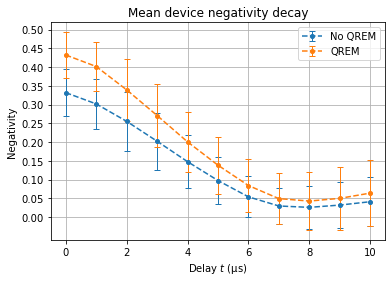

In [61]:
fig = plot_ndecays(n_lists, edges='mean', step=step, label='No QREM')
fig = plot_ndecays(nmit_lists, edges='mean', step=step, label='QREM', fig=fig)

#### Hahn Echo

In [4]:
backend = provider.get_backend('ibm_brisbane')
graphstate = GraphState(backend)

In [5]:
shots = 2048
dd = 'hahn'

In [55]:
job1 = graphstate.run_qst(reps=1, shots=shots, delay=None, dd=dd, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=1, shots=shots, delay=delays[1], dd=dd, qrem=True, execute_only=True)
job3 = graphstate.run_qst(reps=1, shots=shots, delay=delays[2], dd=dd, qrem=True, execute_only=True)
job4 = graphstate.run_qst(reps=1, shots=shots, delay=delays[3], dd=dd, qrem=True, execute_only=True)
job5 = graphstate.run_qst(reps=1, shots=shots, delay=16, dd=dd, qrem=True, execute_only=True)
job6 = graphstate.run_qst(reps=1, shots=shots, delay=20, dd=dd, qrem=True, execute_only=True)
job7 = graphstate.run_qst(reps=1, shots=shots, delay=24, dd=dd, qrem=True, execute_only=True)
job8 = graphstate.run_qst(reps=1, shots=shots, delay=28, dd=dd, qrem=True, execute_only=True)
#job9 = graphstate.run_qst(reps=1, shots=shots, delay=16, dd=dd, qrem=True, execute_only=True)
#job10 = graphstate.run_qst(reps=1, shots=shots, delay=27, dd=dd, qrem=True, execute_only=True)
#job11 = graphstate.run_qst(reps=1, shots=shots, delay=30, dd=dd, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
#list_retrieve_jobs([job1.job_id(), job2.job_id(), job3.job_id(), job4.job_id(), job5.job_id(), job6.job_id(), 
#                    job7.job_id(), job8.job_id(), job9.job_id(), job10.job_id(), job11.job_id()])
list_retrieve_jobs([job1.job_id(), job2.job_id(), job3.job_id(), job4.job_id(), job5.job_id(), job6.job_id(), job7.job_id(), job8.job_id()])

Device: ibm_brisbane (127 qubits)
job1 = backend.retrieve_job('645248990700e062677b8553')
job2 = backend.retrieve_job('645248c1c06eef8d676fb5e7')
job3 = backend.retrieve_job('645248e60700e038e37b8554')
job4 = backend.retrieve_job('6452490ef4655ab8f51b245f')
job5 = backend.retrieve_job('6452493b2cdfd5c81cb49ec7')
job6 = backend.retrieve_job('64524967c06eef83156fb5e8')
job7 = backend.retrieve_job('6452498c87e4827d612651cf')
job8 = backend.retrieve_job('645249b791d9ec9358917988')


In [6]:
#backend = provider.get_backend('ibm_brisbane')
#graphstate = GraphState(backend)
job1 = provider.backend.retrieve_job('645248990700e062677b8553')
job2 = provider.backend.retrieve_job('645248c1c06eef8d676fb5e7')
job3 = provider.backend.retrieve_job('645248e60700e038e37b8554')
job4 = provider.backend.retrieve_job('6452490ef4655ab8f51b245f')
job5 = provider.backend.retrieve_job('6452493b2cdfd5c81cb49ec7')
job6 = provider.backend.retrieve_job('64524967c06eef83156fb5e8')
job7 = provider.backend.retrieve_job('6452498c87e4827d612651cf')
job8 = provider.backend.retrieve_job('645249b791d9ec9358917988')

In [7]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
#rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')
#rho_dict_mit10, rho_dict10 = graphstate.qst_from_result(job10.result(), 'all')
#rho_dict_mit11, rho_dict11 = graphstate.qst_from_result(job11.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 302.98 s


In [8]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
#rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')

n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list3 = calc_negativities(rho_dict3, mode='mean')
nmit_list3 = calc_negativities(rho_dict_mit3, mode='mean')
n_list4 = calc_negativities(rho_dict4, mode='mean')
nmit_list4 = calc_negativities(rho_dict_mit4, mode='mean')
n_list5 = calc_negativities(rho_dict5, mode='mean')
nmit_list5 = calc_negativities(rho_dict_mit5, mode='mean')
n_list6 = calc_negativities(rho_dict6, mode='mean')
nmit_list6 = calc_negativities(rho_dict_mit6, mode='mean')
n_list7 = calc_negativities(rho_dict7, mode='mean')
nmit_list7 = calc_negativities(rho_dict_mit7, mode='mean')
n_list8 = calc_negativities(rho_dict8, mode='mean')
nmit_list8 = calc_negativities(rho_dict_mit8, mode='mean')
#n_list9 = calc_negativities(rho_dict9, mode='mean')
#nmit_list9 = calc_negativities(rho_dict_mit9, mode='mean')


time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 147.21 s


In [ ]:
fig1, idx1 = plot_negativities127(backend, n_list1, nmit_list1, return_idx=True)

In [ ]:
#fig2, idx2 = plot_negativities127(backend, n_list2, nmit_list2, idx=idx1, return_idx=True)
fig2, idx2 = plot_negativities127(backend, n_list2, nmit_list2, return_idx=True)

In [ ]:
#fig3 = plot_negativities127(backend, n_list3, nmit_list3, idx=idx1)
fig3 = plot_negativities127(backend, n_list3, nmit_list3)

In [ ]:
#fig4 = plot_negativities127(backend, n_list4, nmit_list4, idx=idx1)
fig4 = plot_negativities127(backend, n_list4, nmit_list4)

In [ ]:
#fig5 = plot_negativities127(backend, n_list5, nmit_list5, idx=idx1)
fig5 = plot_negativities127(backend, n_list5, nmit_list5)

In [ ]:
#fig6 = plot_negativities127(backend, n_list6, nmit_list6, idx=idx1)
fig6 = plot_negativities127(backend, n_list6, nmit_list6)

In [ ]:
#fig7 = plot_negativities127(backend, n_list7, nmit_list7, idx=idx1)
fig7 = plot_negativities127(backend, n_list7, nmit_list7)

In [ ]:
#fig8 = plot_negativities127(backend, n_list8, nmit_list8, idx=idx1)
fig8 = plot_negativities127(backend, n_list8, nmit_list8)

In [9]:
n_lists_hahn = [n_list1, n_list2, n_list3, n_list4, n_list5, n_list6, n_list7, n_list8]
nmit_lists_hahn = [nmit_list1, nmit_list2, nmit_list3, nmit_list4, nmit_list5, nmit_list6, nmit_list7, nmit_list8]

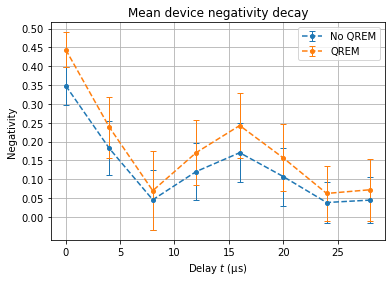

In [18]:
fig = plot_ndecays(n_lists_hahn, edges='mean', step=step, label='No QREM')
fig = plot_ndecays(nmit_lists_hahn, edges='mean', step=step, label='QREM', fig=fig)

#### PDD 1

In [53]:
dd = 'pdd'
pulserate=4

In [54]:
job1 = graphstate.run_qst(reps=1, shots=shots, delay=None, dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=1, shots=shots, delay=delays[1], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job3 = graphstate.run_qst(reps=1, shots=shots, delay=delays[2], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job4 = graphstate.run_qst(reps=1, shots=shots, delay=delays[3], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job5 = graphstate.run_qst(reps=1, shots=shots, delay=delays[4], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job6 = graphstate.run_qst(reps=1, shots=shots, delay=delays[5], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job7 = graphstate.run_qst(reps=1, shots=shots, delay=delays[6], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job8 = graphstate.run_qst(reps=1, shots=shots, delay=delays[7], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job9 = graphstate.run_qst(reps=1, shots=shots, delay=delays[8], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job10 = graphstate.run_qst(reps=1, shots=shots, delay=delays[9], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job11 = graphstate.run_qst(reps=1, shots=shots, delay=delays[10], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
list_retrieve_jobs([job1.job_id(), job2.job_id(), job3.job_id(), job4.job_id(), job5.job_id(), job6.job_id(), 
                    job7.job_id(), job8.job_id(), job9.job_id(), job10.job_id(), job11.job_id()])
#list_retrieve_jobs([job1.job_id(), job2.job_id(), job3.job_id(), job4.job_id(), job5.job_id(), job6.job_id(), job7.job_id(), job8.job_id()]

Device: ibm_brisbane (127 qubits)
job1 = provider.backend.retrieve_job('ch98takrpl4d0vo14kc0')
job2 = provider.backend.retrieve_job('ch98u1k4k9li68o9q9v0')
job3 = provider.backend.retrieve_job('ch98uv9ccmlc5k9lmhs0')
job4 = provider.backend.retrieve_job('ch9904g1l2f3uq930op0')
job5 = provider.backend.retrieve_job('ch991f81l2f3uq931nr0')
job6 = provider.backend.retrieve_job('ch992vs4k9li68o9tp1g')
job7 = provider.backend.retrieve_job('ch994pva54942menju0g')
job8 = provider.backend.retrieve_job('ch996r81l2f3uq935fl0')
job9 = provider.backend.retrieve_job('ch999344k9li68oa2320')
job10 = provider.backend.retrieve_job('ch99brhccmlc5k9lvud0')
job11 = provider.backend.retrieve_job('ch99epg1l2f3uq93bckg')


In [62]:
backend = provider.get_backend('ibm_brisbane')
graphstate = GraphState(backend)
job1 = provider.backend.retrieve_job('ch98takrpl4d0vo14kc0')
job2 = provider.backend.retrieve_job('ch98u1k4k9li68o9q9v0')
job3 = provider.backend.retrieve_job('ch98uv9ccmlc5k9lmhs0')
job4 = provider.backend.retrieve_job('ch9904g1l2f3uq930op0')
job5 = provider.backend.retrieve_job('ch991f81l2f3uq931nr0')
job6 = provider.backend.retrieve_job('ch992vs4k9li68o9tp1g')
job7 = provider.backend.retrieve_job('ch994pva54942menju0g')
job8 = provider.backend.retrieve_job('ch996r81l2f3uq935fl0')
job9 = provider.backend.retrieve_job('ch999344k9li68oa2320')
job10 = provider.backend.retrieve_job('ch99brhccmlc5k9lvud0')
job11 = provider.backend.retrieve_job('ch99epg1l2f3uq93bckg')

In [63]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')
rho_dict_mit10, rho_dict10 = graphstate.qst_from_result(job10.result(), 'all')
rho_dict_mit11, rho_dict11 = graphstate.qst_from_result(job11.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 196.38 s


In [64]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')
rho_dict_mit10, rho_dict10 = graphstate.qst_from_result(job10.result(), 'all')
rho_dict_mit11, rho_dict11 = graphstate.qst_from_result(job11.result(), 'all')

n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list3 = calc_negativities(rho_dict3, mode='mean')
nmit_list3 = calc_negativities(rho_dict_mit3, mode='mean')
n_list4 = calc_negativities(rho_dict4, mode='mean')
nmit_list4 = calc_negativities(rho_dict_mit4, mode='mean')
n_list5 = calc_negativities(rho_dict5, mode='mean')
nmit_list5 = calc_negativities(rho_dict_mit5, mode='mean')
n_list6 = calc_negativities(rho_dict6, mode='mean')
nmit_list6 = calc_negativities(rho_dict_mit6, mode='mean')
n_list7 = calc_negativities(rho_dict7, mode='mean')
nmit_list7 = calc_negativities(rho_dict_mit7, mode='mean')
n_list8 = calc_negativities(rho_dict8, mode='mean')
nmit_list8 = calc_negativities(rho_dict_mit8, mode='mean')
n_list9 = calc_negativities(rho_dict9, mode='mean')
nmit_list9 = calc_negativities(rho_dict_mit9, mode='mean')
n_list10 = calc_negativities(rho_dict10, mode='mean')
nmit_list10 = calc_negativities(rho_dict_mit10, mode='mean')
n_list11 = calc_negativities(rho_dict11, mode='mean')
nmit_list11 = calc_negativities(rho_dict_mit11, mode='mean')

time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 167.35 s


In [65]:
n_lists_pdd1 = [n_list1, n_list2, n_list3, n_list4, n_list5, n_list6, n_list7, n_list8, n_list9, n_list10, n_list11]
nmit_lists_pdd1 = [nmit_list1, nmit_list2, nmit_list3, nmit_list4, nmit_list5, nmit_list6, nmit_list7, nmit_list8, nmit_list9, nmit_list10, nmit_list11]

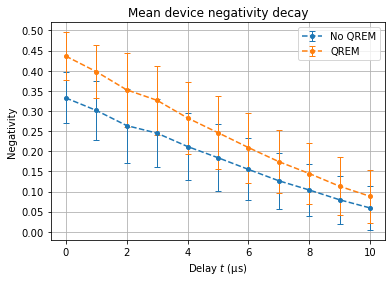

In [66]:
fig = plot_ndecays(n_lists_pdd1, edges='mean', step=step, label='No QREM')
fig = plot_ndecays(nmit_lists_pdd1, edges='mean', step=step, label='QREM', fig=fig)

#### PDD 2

In [55]:
dd = 'pdd'
pulserate=8

In [56]:
job1 = graphstate.run_qst(reps=1, shots=shots, delay=None, dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=1, shots=shots, delay=delays[1], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job3 = graphstate.run_qst(reps=1, shots=shots, delay=delays[2], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job4 = graphstate.run_qst(reps=1, shots=shots, delay=delays[3], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job5 = graphstate.run_qst(reps=1, shots=shots, delay=delays[4], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job6 = graphstate.run_qst(reps=1, shots=shots, delay=delays[5], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job7 = graphstate.run_qst(reps=1, shots=shots, delay=delays[6], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job8 = graphstate.run_qst(reps=1, shots=shots, delay=delays[7], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job9 = graphstate.run_qst(reps=1, shots=shots, delay=delays[8], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job10 = graphstate.run_qst(reps=1, shots=shots, delay=delays[9], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)
job11 = graphstate.run_qst(reps=1, shots=shots, delay=delays[10], dd=dd, pulserate=pulserate, qrem=True, execute_only=True)

print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
list_retrieve_jobs([job1.job_id(), job2.job_id(), job3.job_id(), job4.job_id(), job5.job_id(), job6.job_id(), 
                    job7.job_id(), job8.job_id(), job9.job_id(), job10.job_id(), job11.job_id()])
#list_retrieve_jobs([job1.job_id(), job2.job_id(), job3.job_id(), job4.job_id(), job5.job_id(), job6.job_id(), job7.job_id(), job8.job_id()]

Device: ibm_brisbane (127 qubits)
job1 = provider.backend.retrieve_job('ch99fdg1l2f3uq93bs40')
job2 = provider.backend.retrieve_job('ch99ggrmre35qqpk7cng')
job3 = provider.backend.retrieve_job('ch99i3hccmlc5k9m4io0')
job4 = provider.backend.retrieve_job('ch99k51ccmlc5k9m60kg')
job5 = provider.backend.retrieve_job('ch99mjs4k9li68oabptg')
job6 = provider.backend.retrieve_job('ch99phva54942meo28gg')
job7 = provider.backend.retrieve_job('ch99t244k9li68oagap0')
job8 = provider.backend.retrieve_job('ch9a0uc4k9li68oaisk0')
job9 = provider.backend.retrieve_job('ch9a5c01l2f3uq93r6d0')
job10 = provider.backend.retrieve_job('ch9aa7rmre35qqpkof10')
job11 = provider.backend.retrieve_job('ch9afi3mre35qqpkrm0g')


In [68]:
backend = provider.get_backend('ibm_brisbane')
graphstate = GraphState(backend)
job1 = provider.backend.retrieve_job('ch99fdg1l2f3uq93bs40')
job2 = provider.backend.retrieve_job('ch99ggrmre35qqpk7cng')
job3 = provider.backend.retrieve_job('ch99i3hccmlc5k9m4io0')
job4 = provider.backend.retrieve_job('ch99k51ccmlc5k9m60kg')
job5 = provider.backend.retrieve_job('ch99mjs4k9li68oabptg')
job6 = provider.backend.retrieve_job('ch99phva54942meo28gg')
job7 = provider.backend.retrieve_job('ch99t244k9li68oagap0')
job8 = provider.backend.retrieve_job('ch9a0uc4k9li68oaisk0')
job9 = provider.backend.retrieve_job('ch9a5c01l2f3uq93r6d0')
job10 = provider.backend.retrieve_job('ch9aa7rmre35qqpkof10')
job11 = provider.backend.retrieve_job('ch9afi3mre35qqpkrm0g')

In [69]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')
rho_dict_mit10, rho_dict10 = graphstate.qst_from_result(job10.result(), 'all')
rho_dict_mit11, rho_dict11 = graphstate.qst_from_result(job11.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 189.08 s


In [70]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')
rho_dict_mit10, rho_dict10 = graphstate.qst_from_result(job10.result(), 'all')
rho_dict_mit11, rho_dict11 = graphstate.qst_from_result(job11.result(), 'all')

n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list3 = calc_negativities(rho_dict3, mode='mean')
nmit_list3 = calc_negativities(rho_dict_mit3, mode='mean')
n_list4 = calc_negativities(rho_dict4, mode='mean')
nmit_list4 = calc_negativities(rho_dict_mit4, mode='mean')
n_list5 = calc_negativities(rho_dict5, mode='mean')
nmit_list5 = calc_negativities(rho_dict_mit5, mode='mean')
n_list6 = calc_negativities(rho_dict6, mode='mean')
nmit_list6 = calc_negativities(rho_dict_mit6, mode='mean')
n_list7 = calc_negativities(rho_dict7, mode='mean')
nmit_list7 = calc_negativities(rho_dict_mit7, mode='mean')
n_list8 = calc_negativities(rho_dict8, mode='mean')
nmit_list8 = calc_negativities(rho_dict_mit8, mode='mean')
n_list9 = calc_negativities(rho_dict9, mode='mean')
nmit_list9 = calc_negativities(rho_dict_mit9, mode='mean')
n_list10 = calc_negativities(rho_dict10, mode='mean')
nmit_list10 = calc_negativities(rho_dict_mit10, mode='mean')
n_list11 = calc_negativities(rho_dict11, mode='mean')
nmit_list11 = calc_negativities(rho_dict_mit11, mode='mean')

time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 164.60 s


In [71]:
n_lists_pdd2 = [n_list1, n_list2, n_list3, n_list4, n_list5, n_list6, n_list7, n_list8, n_list9, n_list10, n_list11]
nmit_lists_pdd2 = [nmit_list1, nmit_list2, nmit_list3, nmit_list4, nmit_list5, nmit_list6, nmit_list7, nmit_list8, nmit_list9, nmit_list10, nmit_list11]

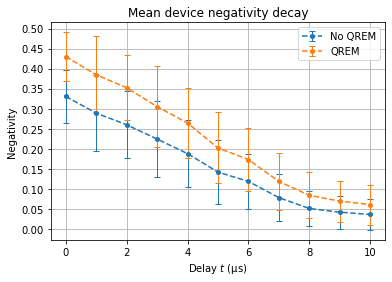

In [72]:
fig = plot_ndecays(n_lists_pdd2, edges='mean', step=step, label='No QREM')
fig = plot_ndecays(nmit_lists_pdd2, edges='mean', step=step, label='QREM', fig=fig)

#### Comparison Plots

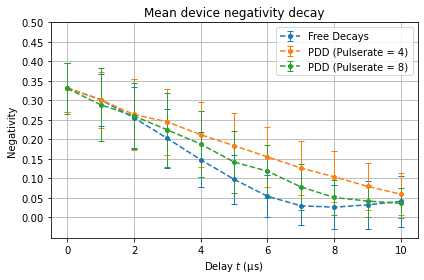

In [78]:
fig = plot_ndecays(n_lists, edges='mean', step=step, label='Free Decays')
fig = plot_ndecays(n_lists_pdd1, edges='mean', step=step, label='PDD (Pulserate = 4)', fig=fig)
fig = plot_ndecays(n_lists_pdd2, edges='mean', step=step, label='PDD (Pulserate = 8)', fig=fig)

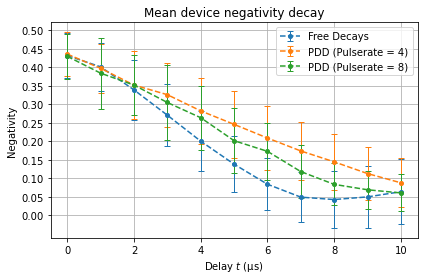

In [79]:
fig = plot_ndecays(nmit_lists, edges='mean', step=step, label='Free Decays')
fig = plot_ndecays(nmit_lists_pdd1, edges='mean', step=step, label='PDD (Pulserate = 4)', fig=fig)
fig = plot_ndecays(nmit_lists_pdd2, edges='mean', step=step, label='PDD (Pulserate = 8)', fig=fig)

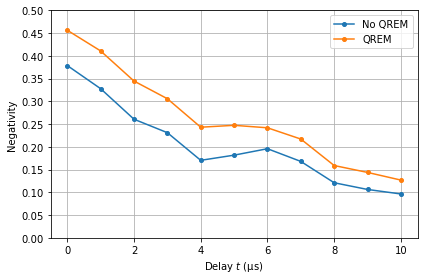

In [126]:
edges = (37, 38)
fig = plot_ndecays(n_lists_pdd1, edges=edges, step=step, label='No QREM')
fig = plot_ndecays(nmit_lists_pdd1, edges=edges, step=step, label='QREM', fig=fig)